<a href="https://colab.research.google.com/github/PatienceNyasulu/-Impact-of-Weather-on-WWII/blob/main/Main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Import dependencies

In [ ]:
import os
import pickle
import numpy as np
from tqdm.notebook import tqdm
import tensorflow as tf
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Dense, LSTM,Embedding,Dropout, add
from gensim.models import Word2Vec

Load the VGG16 pretrained model

In [ ]:
model = VGG16()
model = Model(inputs = model.inputs, outputs = model.layers[-2].output)
print(model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Loading Dataset : Flickr8k that includes images and captions.txt

In [ ]:
Base = '/content/drive/MyDrive/datasets_imagecap'

Extracting features

In [ ]:
features = {}
directory = os.path.join(Base, 'Images')
for image_name in tqdm(os.listdir(directory)):
    img_path = directory + '/' + image_name
    image = load_img(img_path, target_size = (224,224))
    ## convert image pixel to numpy array
    image = img_to_array(image)
    ## reshape dta for model
    image = image.reshape((1,image.shape[0], image.shape[1], image.shape[2]))
    ## preproces for vgg
    image = preprocess_input(image)
    ## extract feature
    feature = model.predict(image, verbose = 0) ## it will be clean
    ## get image id
    image_id =image_name.split('.')[0]
    ## store feature
    features[image_id] = feature



  0%|          | 0/8092 [00:00<?, ?it/s]

In [ ]:
#storing in pickle
pickle.dump(features, open(os.path.join(Base, 'features.pkl'),'wb'))

In [ ]:
#load features from pickle
with open(os.path.join(Base,'features.pkl'),'rb') as f:
    features = pickle.load(f)

In [ ]:
from pickle import load
# load doc into memory
def load_doc(filename):
    # open the file as read only
    file = open(filename, 'r')
    # read all text
    text = file.read()
    # close the file
    file.close()
    return text

# load a pre-defined list of photo identifiers
def load_set(filename):
    doc = load_doc(filename)
    dataset = list()
    # process line by line
    for line in doc.split('\n'):
        # skip empty lines
        if len(line) < 1:
            continue
        # get the image identifier
        identifier = line.split('.')[0]
        dataset.append(identifier)
    return set(dataset)

# load clean descriptions into memory
def load_clean_descriptions(filename, dataset):
    # load document
    doc = load_doc(filename)
    descriptions = dict()
    for line in doc.split('\n'):
        # split line by white space
        tokens = line.split()
        # split id from description
        image_id, image_desc = tokens[0], tokens[1:]
        # skip images not in the set
        if image_id in dataset:
            # create list
            if image_id not in descriptions:
                descriptions[image_id] = list()
            # wrap description in tokens
            desc = 'startseq ' + ' '.join(image_desc) + ' endseq'
            # store
            descriptions[image_id].append(desc)
    return descriptions

# load photo features
def load_photo_features(filename, dataset):
    # load all features
    all_features = load(open(filename, 'rb'))
    # filter features
    features = {k: all_features[k] for k in dataset}
    return features

Load Caption data

In [ ]:
with open(os.path.join(Base, 'captions.txt'),'r') as df:
    next(df)
    captions_doc = df.read()

Create mapping of image to captions

In [ ]:
maping = {}
## process line
for line in tqdm(captions_doc.split('\n')):
    tokens = line.split(',')
    if len(line)<2:
        continue
    image_id,caption = tokens[0], tokens[1:]
    image_id = image_id.split('.')[0]
    caption  = ' '.join(caption)

    if image_id not in maping:
        maping[image_id] = []
    #store the caption
    maping[image_id].append(caption)

  0%|          | 0/40456 [00:00<?, ?it/s]

In [ ]:
len(maping)

8091

# preprocessing the caption

In [ ]:
maping['1001773457_577c3a7d70']

['A black dog and a spotted dog are fighting',
 'A black dog and a tri-colored dog playing with each other on the road .',
 'A black dog and a white dog with brown spots are staring at each other in the street .',
 'Two dogs of different breeds looking at each other on the road .',
 'Two dogs on pavement moving toward each other .']

In [ ]:
def clean(mapping):
    for key, captions in mapping.items():
        for i in range(len(captions)):
            # taking only one at a time
            caption = captions[i]
            ## processing steps
            caption = caption.lower() # lower case
            caption = caption.replace('[^A-Za-z]', '') ## replace special character
            caption = caption.replace('/s+', ' ') ## speacial additional spaces
            ## add start and end tags to the caption
            caption = 'start' + ' '.join([word for word in caption.split() if len(word)>1]) + ' end'
            captions[i] = caption


In [ ]:
clean(maping)

In [ ]:
all_caption = []
for key in maping:
    for caption in maping[key]:
        all_caption.append(caption)

len(all_caption)

40455

In [ ]:
all_caption[:10]

['startchild in pink dress is climbing up set of stairs in an entry way end',
 'startgirl going into wooden building end',
 'startlittle girl climbing into wooden playhouse end',
 'startlittle girl climbing the stairs to her playhouse end',
 'startlittle girl in pink dress going into wooden cabin end',
 'startblack dog and spotted dog are fighting end',
 'startblack dog and tri-colored dog playing with each other on the road end',
 'startblack dog and white dog with brown spots are staring at each other in the street end',
 'starttwo dogs of different breeds looking at each other on the road end',
 'starttwo dogs on pavement moving toward each other end']

Tokenize the text

In [ ]:

tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_caption)
vocab_size = len(tokenizer.word_index) +1
vocab_size

9352

In [ ]:
## get the maximum length of the caption for padding and model
max_length = max(len(caption.split())for caption in all_caption)


# Encode captions
sequences = tokenizer.texts_to_sequences(all_caption)
max_seq_length = max(len(seq) for seq in sequences)

# Pad sequences
padded_sequences = pad_sequences(sequences, maxlen=max_seq_length, padding='post')

max_length

34

In [ ]:
## storing in pickle
pickle.dump(features, open(os.path.join(Base, 'tokenizer.pkl'),'wb'))

Word embeddings

Splitting the data

In [ ]:
image_ids = list(maping.keys())
split = int(len(image_ids)*0.90)
train = image_ids[:split]
test = image_ids[split:]

Create data generator

In [ ]:
def data_generator(data_keys, maping, featuers, tokenizer, max_length, vocab_size, batch_size):
    # loop over images
    X1, X2, y = list(), list(),list()
    n = 0
    while 1:
        for key in data_keys:
            n+=1
            captions = maping[key]
            for caption in captions:
                seq = tokenizer.texts_to_sequences([caption])[0]
                # split the sequence into x,y pairs
                for i in range(1,len(seq)):
                    in_seq, out_seq = seq[:i],seq[i]
                    in_seq = pad_sequences([in_seq], maxlen = max_length)[0]
                    out_seq = to_categorical([out_seq], num_classes = vocab_size)[0]
                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)
            if n == batch_size:
                X1,X2,y = np.array(X1),np.array(X2),np.array(y)
                yield [X1,X2], y
                X1, X2, y = list(), list(),list()
                n = 0



## Model

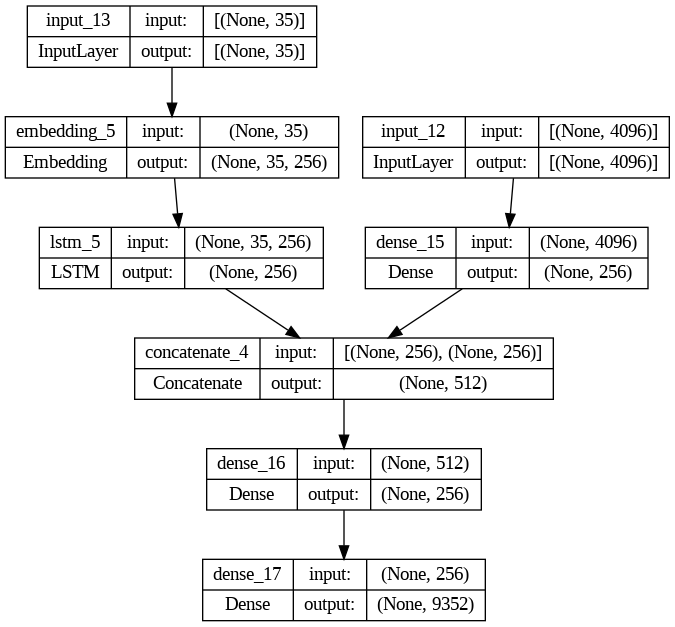

In [ ]:
from tensorflow.keras.layers import concatenate
embedding_dim = 256

image_input = Input(shape=(4096,))
image_dense = Dense(256, activation='relu')(image_input)

text_input = Input(shape=(max_seq_length,))
text_embedding = Embedding(vocab_size, embedding_dim, mask_zero=True)(text_input)
text_lstm = LSTM(256)(text_embedding)

merged = concatenate([text_lstm, image_dense])  # Concatenate the outputs
merged_dense = Dense(256, activation='relu')(merged)

output = Dense(vocab_size, activation='softmax')(merged_dense)
model = Model(inputs=[text_input, image_input], outputs=output)

model.compile(loss='categorical_crossentropy', optimizer='adam')

## plot model
plot_model(model,show_shapes = True)

## Train the model

In [ ]:
import numpy as np

In [ ]:
epochs = 6
batch_size = 32
steps = len(train)//batch_size
for i in range(epochs):
    ## create data generator
    generator = data_generator(train,maping,features, tokenizer,max_length, vocab_size,batch_size)
    # fit for one epoch
    model.fit(generator,epochs = 1, steps_per_epoch = steps, verbose = 1)

InvalidArgumentError: ignored

In [ ]:
## save the model
model.save(os.path.join(Base, 'model.h5'))

Generating Captions